In [1]:
import cv2


from matplotlib import pyplot as plt

# This opens an inteactive figure - use it in part B
import matplotlib
matplotlib.use('TkAgg')

import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import null_space

# This specifies the way plots behave in jupyter notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (8.0, 8.0) # set default size of plots
plt.rcParams['image.cmap'] = 'gray'


import platform
print("Python version: ", platform.python_version())
print("Numpy version: ", np.__version__)

Python version:  3.11.5
Numpy version:  1.24.2


compute the 3D structure from a pair of rectified images.


**The input:**\
    **a.** A pair of two rectified images, $im1$ and $im2$ (*view1.png and view5.png*).\
    **b.** A window size $(s_x,s_y$).\
    **c.** Disparity range $(d_{min},d_{max})$ (see below).

**The output:**\
**a.** A matrix, $D$ with the disparity map for the left image.\
**b.** Three matrices X, Y, Z with the x, y, z-coordinates of each pixel in the left image. Assign zero for pixels for which the disparity was not computed.

Note: all matrices $im1, im2, D, X, Y, Z$ have the same dimensions.

**Instructions:**
1. Read the two images view1.png and view5.png, and apply the functions to this pair of images.

   
2. Write a function that receives two rectified images, and compute dense matching along lines with the same $y-$coordinate.
    * You can use any of the descriptors from Part B. The patch size should be given as a parameter.
    * Use NCC for the similarity measure.
    * You can assume that you are given the range of disparities, $d_{min},d_{max}$ as an input. \
      For example, if  $(d_{min},d_{max})=(20,120)$ it follows that the corresponding point of  $(x,y)$ in the left image, is in the range $(x-120:x-20,y)$ in the right image.
    * Consider matching with and without order preseving. 
    * List all parameters you use for your function.
    * Hints on efficient implementation is given below.
    
        
3. Write a function that computes the disparity based on (2).  
    * **Display** the disparity $D$ map as an image
   


In [2]:
# Load the images
img1_path = 'images/view1.tif'
img2_path = 'images/view5.tif'

img_L = cv2.imread(img1_path, cv2.IMREAD_GRAYSCALE)
img_R = cv2.imread(img2_path, cv2.IMREAD_GRAYSCALE)

hight, width = img_L.shape

print(hight, width)

555 695


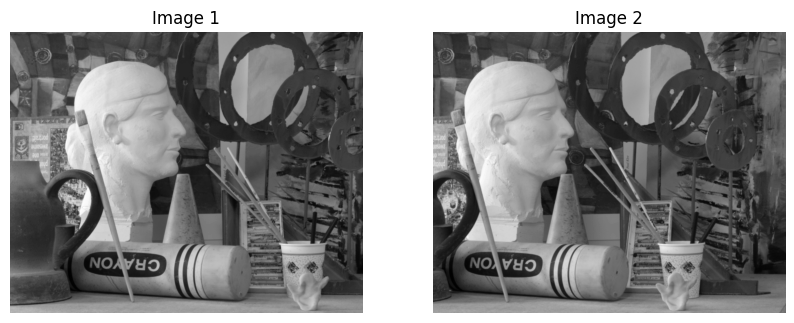

(555, 695)


In [3]:
# Display the images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(img_L, cmap='gray')
plt.title('Image 1')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_R, cmap='gray')
plt.title('Image 2')
plt.axis('off')

plt.show()
print(img_L.shape)

In [4]:
def patch_NCC(patch1, patch2):
    #patch 1 and 2 are 1D vector, the function returns (v-u)/(||v||*||u||)
    u = patch1
    normal_u=np.linalg.norm(u)
    normalized_u = u / normal_u
    
    v = patch2
    normal_v=np.linalg.norm(v)
    normalized_v = v / normal_v

    return np.matmul(normalized_u, normalized_v.T)

In [5]:
def patch_from_im_q3(im,p,window_size):
    #return flat patch vector from a point when p is in the left high corner
    y, x = p
    patch_vector = im[x:x + window_size, y:y + window_size]
    return patch_vector.flatten()

In [6]:
def disparity_map(img_L, img_R, window_size, disparity_range):
    img_hight, img_width = img_L.shape
    disparity_map = np.zeros((img_hight, img_width))
    #s_y, s_x = window_size
    d_min, d_max = disparity_range

    for y in range(0, img_hight - window_size):
        for x in range(d_max, img_width - window_size):
            #run on each relevent pixel in the image
            p_l = x,y
            patch_L = patch_from_im_q3(img_L, p_l, window_size)

            best_ncc_score = 0
            best_disparity = 0
            for d in range(d_min, d_max + 1):
                #this loop compares patch from left image to each patch from right image 
                # for the same y and x in (x + Disparity range()
                p_r = x - d ,y

                patch_R = patch_from_im_q3(img_R, p_r, window_size)
                ncc_score = patch_NCC(patch_L, patch_R)

                #check if the current patch from the right image is better fit for the left image patch
                if ncc_score > best_ncc_score:
                    best_ncc_score = ncc_score
                    best_disparity = d

            disparity_map[y, x] = best_disparity

    return disparity_map

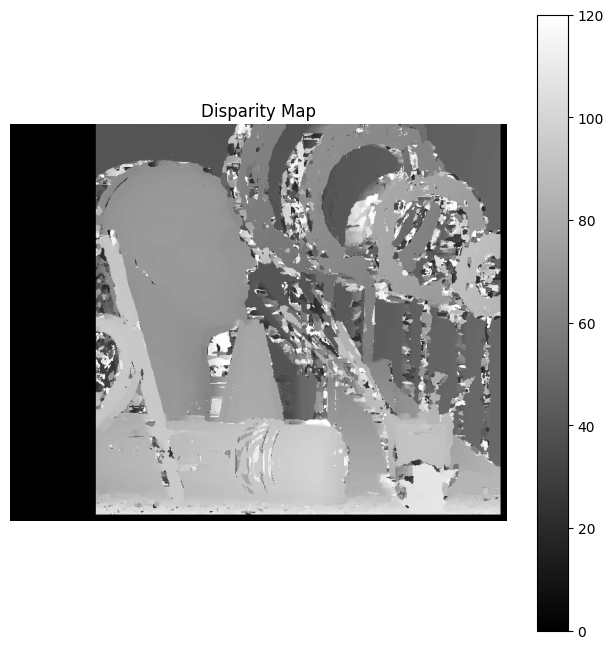

In [7]:
# Define parameters
window_size = 9  # Example value
dmin, dmax = 20, 120  # Example values
disparity_range = dmin, dmax
# Compute Disparity Map
D = disparity_map(img_L, img_R, window_size, disparity_range)

# Display the Disparity Map
plt.imshow(D, cmap='gray')
plt.colorbar()
plt.title('Disparity Map')
plt.axis('off')
plt.show()

4. Compute the depth map using the disparity.
    * Assume that scaled focal lengths ($f$ in the presentation) are $α_x=α_y=1$.
    * The distance between the cameras is 160mm.
    * Add to your disparity depth map the value 100, since images were cropped. 
    * Display the disparity as an image. 


5. Compute the matrices X,Y,Z
    * Present the object given by X,Y,Z using a 3D plot.

In [75]:
def compute_XYZ(disparity_map, camera_dist=160, focal_length=1, offset=100 ):

    rows_num, cols_num = disparity_map.shape
    Z = (focal_length * camera_dist)/(disparity_map  + offset)

    X, Y = np.meshgrid(np.arange(cols_num), np.arange(rows_num))
    X = X / focal_length
    Y = Y / focal_length

    return X, Y, Z

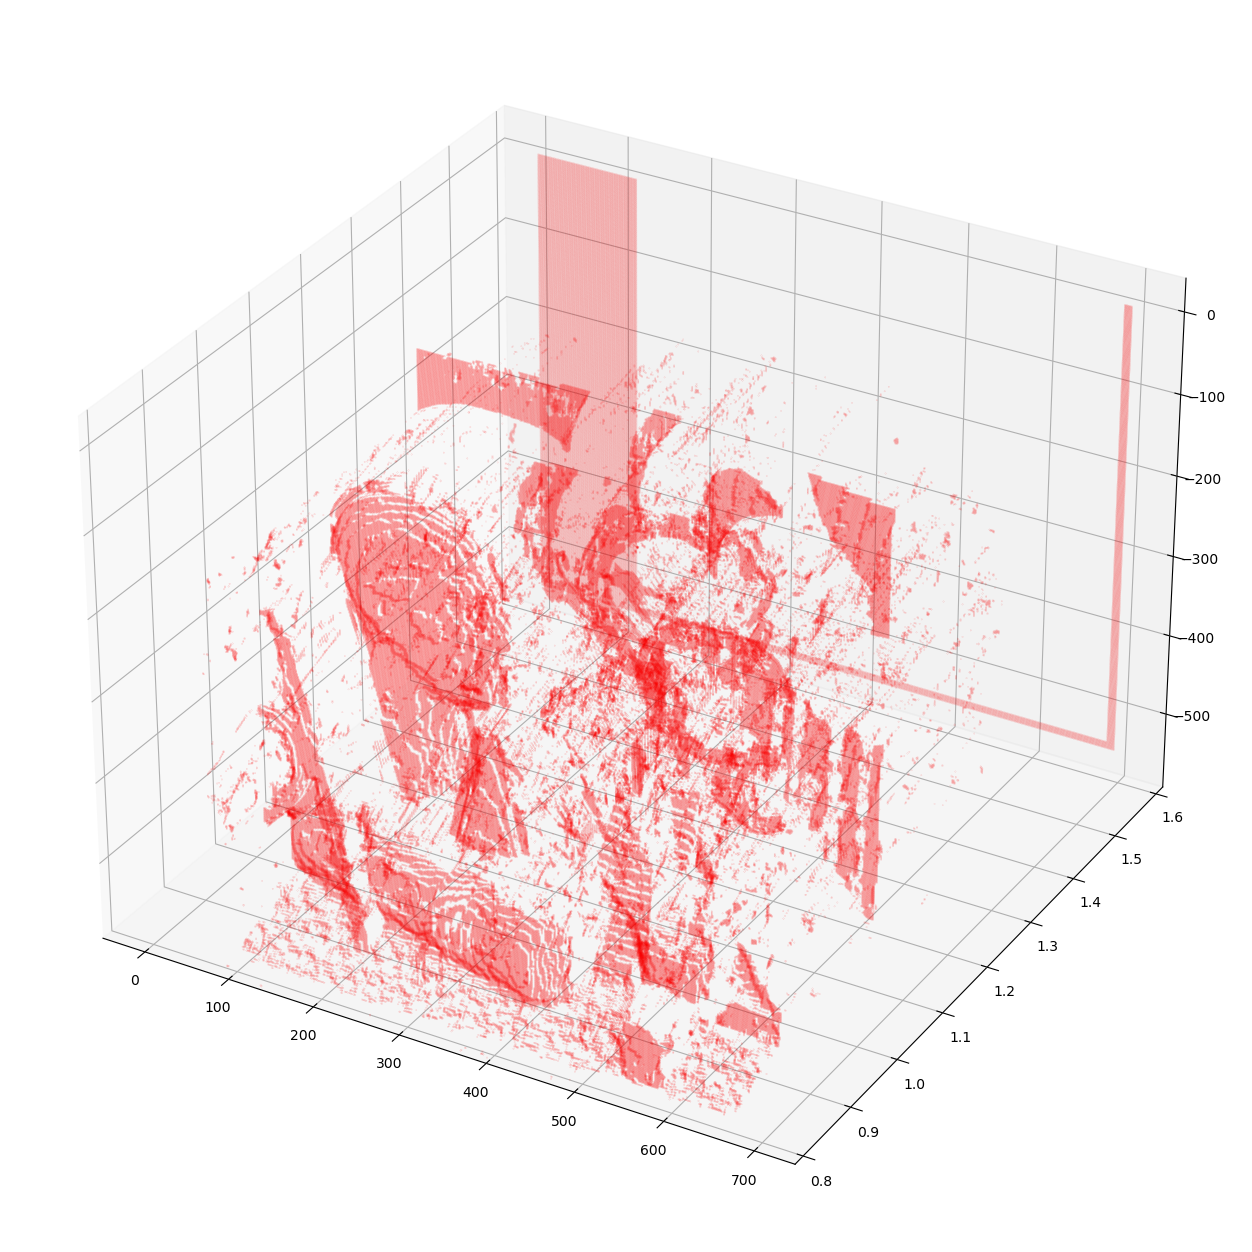

In [76]:
X, Y, Z = compute_XYZ(D)
# Display the 3D Object
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X, Z, -Y, c='r', s=0.005)
ax.set_ylim([0.8, 1.6])

plt.show()